In [1]:
# First we grab the model and the unembedding weight matrix
import torch
from easy_transformer import EasyTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(f"Using {device} device")
torch.set_grad_enabled(False)

model = EasyTransformer.from_pretrained('gpt2').to(device)

# Convenience function for decoding token
decode = model.tokenizer.decode

unembed = model.unembed.W_U.data
unembed_bias = model.unembed.b_U.data
d_model = model.cfg.d_model
d_vocab = model.cfg.d_vocab

/home/giles/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:83: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Using cpu device
Loading model: gpt2


Using pad_token, but it is not set yet.


Moving model to device:  cpu
Finished loading pretrained model gpt2 into EasyTransformer!
Moving model to device:  cpu


In [2]:
# Choose some nouns from nltk
from nltk.corpus import wordnet as wn
import nltk
nltk.download('omw-1.4')
nltk.download('wordnet')

num_wanted = 200
seen = set()
chosen_tokens = []
for synset in wn.all_synsets('n'):
    tok = ' ' + synset.name().split('.')[0]
    enc = model.tokenizer.encode(tok)
    if len(enc) == 1 and tok not in seen:
        chosen_tokens.append(enc[0])
        seen.add(tok)

import random
random.seed(12345)
chosen_tokens = random.sample(chosen_tokens, k=num_wanted)
chosen_strs = [decode(t) for t in chosen_tokens]

print(chosen_strs)

[nltk_data] Downloading package omw-1.4 to /home/giles/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/giles/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


[' cyan', ' stiff', ' emergence', ' venom', ' midnight', ' prosperity', ' groin', ' tablespoon', ' hearing', ' compact', ' challenge', ' preference', ' dating', ' tongue', ' role', ' height', ' capacitor', ' chat', ' civilization', ' siege', ' salad', ' profiling', ' constraint', ' shoulder', ' undergraduate', ' stranger', ' cooperation', ' fingerprint', ' tell', ' ancestry', ' concussion', ' substantive', ' ceremony', ' inspection', ' awakening', ' pedestrian', ' upset', ' riot', ' ranch', ' motel', ' drive', ' technique', ' puck', ' traction', ' poem', ' counselor', ' graves', ' gray', ' space', ' interchange', ' ob', ' listing', ' decimal', ' recoil', ' affairs', ' fabric', ' football', ' peak', ' grain', ' song', ' bartender', ' karma', ' government', ' totalitarian', ' transistor', ' stag', ' ordinance', ' intoxication', ' loader', ' noon', ' panel', ' arsenic', ' assignment', ' kid', ' visitation', ' conservatism', ' cere', ' traitor', ' lack', ' gall', ' indic', ' god', ' confin

In [3]:
# Attempt to calculate the "auspicious vectors" using the Moore-Penrose pseudoinverse
ausp = torch.nn.functional.normalize(torch.linalg.pinv(unembed.to('cpu')), dim=1)

<BarContainer object of 200 artists>

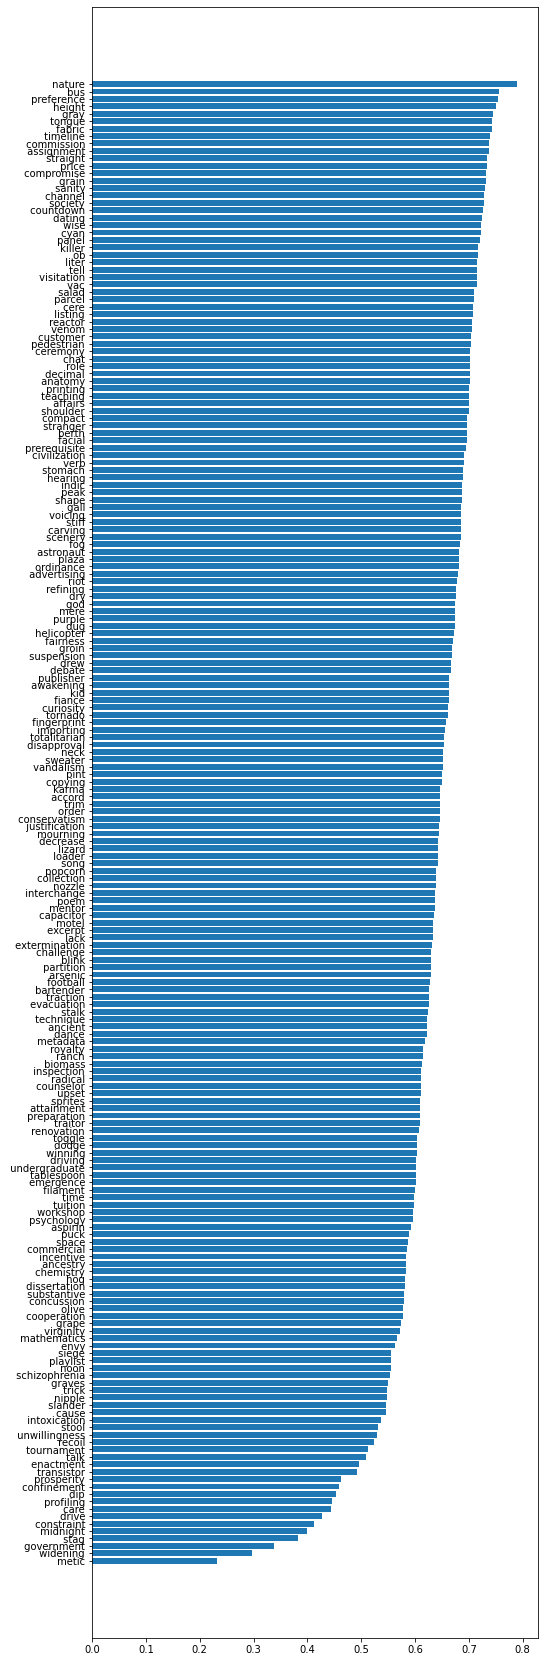

In [9]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 30]

# Compute similarity between embedding vector and auspicious vector for each of our chosen tokens
cosine_sim = torch.nn.CosineSimilarity(dim=0)
pairs = [None] * len(chosen_tokens)
cosine_sims = [None] * len(chosen_tokens)
for i,t in enumerate(chosen_tokens):
    em = model.embed.W_E.data[t,:]
    au = ausp[t,:]
    cs = cosine_sim(em, au)
    cosine_sims[i] = cs
    pairs[i] = (cs, chosen_strs[i])

pairs.sort()
xs = [p[0] for p in pairs]
ls = [p[1] for p in pairs]

fig, ax = plt.subplots()
ax.set_yticks(range(len(xs)))
ax.set_yticklabels(ls, minor=False)

plt.barh(y=range(len(xs)), width=xs)

In [29]:
# A function for understanding a vector in embedding space
def print_embed_vector(v):
    if v.shape != (d_model,):
        raise Exception(f"Shape should be [{d_model}], got {v.shape}")
    logits = torch.matmul(v.to(device), unembed)
    probs = torch.nn.functional.softmax(logits, dim=0)
    values = [(v.item(),i) for i,v in enumerate(logits)]
    values.sort(reverse=True)
    for i in range(10):
        j = values[i][1]
        print(f'  {decode(j):10} {values[i][0]} {probs[j]}')
    print('  ...')
    for i in range(d_vocab-5,d_vocab):
        j = values[i][1]
        print(f'  {decode(j):10} {values[i][0]} {probs[j]}')

n = 20
for i in range(n):
    print(chosen_strs[i])
    em = torch.nn.functional.normalize(model.embed.W_E.data[chosen_tokens[i],:], dim=0)
    print_embed_vector(em)

 cyan
   cyan      3.7972123622894287 0.0008597726700827479
   Cyan      2.174647092819214 0.00016971197328530252
   cryst     1.6274166107177734 9.818685066420585e-05
   horizont  1.5378789901733398 8.977752440841869e-05
   destro    1.419580101966858 7.97610919107683e-05
   pestic    1.3317978382110596 7.305798499146476e-05
  senal      1.3224416971206665 7.237764657475054e-05
   advoc     1.3193230628967285 7.21522665116936e-05
   satell    1.3165159225463867 7.195000944193453e-05
   gobl      1.3164687156677246 7.19466115697287e-05
  ...
   Peterson  -0.7402529120445251 9.199994565278757e-06
   Rel       -0.7638579607009888 8.985369277070276e-06
  elle       -0.7639634609222412 8.98442249308573e-06
   Eng       -0.7665844559669495 8.960903869592585e-06
  -          -0.7754854559898376 8.881498615664896e-06
 stiff
   stiff     3.284558057785034 0.0005136785330250859
   streng    1.7955405712127686 0.00011588289635255933
   nodd      1.7386274337768555 0.00010947180999210104
   chall

   challenge 3.3019251823425293 0.0005236280849203467
   challeng  2.7510483264923096 0.00030184234492480755
   challenges 2.173788070678711 0.00016946467803791165
  chall      2.0640623569488525 0.0001518539065727964
  Chall      2.0076096057891846 0.00014351881691254675
   Challenges 1.9061928987503052 0.000129677340737544
   Challenge 1.894277811050415 0.0001281414006371051
   challengers 1.8013744354248047 0.00011677289148792624
   challenging 1.6853457689285278 0.0001039803828462027
   chall     1.6593592166900635 0.00010131309682037681
  ...
  ,          -0.7008136510848999 9.564350875734817e-06
  *          -0.7390469908714294 9.205576134263538e-06
  med        -0.743967592716217 9.160391527984757e-06
   unspecified -0.7571575045585632 9.040361874212977e-06
   *         -0.7575655579566956 9.036672054207884e-06
 preference
   preference 3.7237603664398193 0.0007996981730684638
   preferences 2.533163070678711 0.00024313990434166044
   Preferences 1.8844584226608276 0.00012709469